# Task
Import data from BigQuery into a pandas DataFrame.

## Install the necessary libraries

### Subtask:
Install the `google-cloud-bigquery` library to interact with BigQuery.


**Reasoning**:
Install the `google-cloud-bigquery` library using pip.



In [1]:
%pip install google-cloud-bigquery

## Authenticate to google cloud

### Subtask:
Authenticate your Colab environment to access Google Cloud services, including BigQuery.


**Reasoning**:
Authenticate the user to access Google Cloud services, including BigQuery.



In [2]:
from google.colab import auth
auth.authenticate_user()

## Initialize a bigquery client

### Subtask:
Create a BigQuery client object to interact with the BigQuery API.


**Reasoning**:
Import the bigquery class and instantiate a client object as instructed.



In [3]:
from google.cloud import bigquery

client = bigquery.Client()

In [4]:
# Core libraries
import pandas as pd
from google.cloud import bigquery

# ML + preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

## Construct a sql query

### Subtask:
Write a SQL query to select the data you want to import.


**Reasoning**:
Define a SQL query string to select data from the BigQuery public dataset.



In [5]:
sql_query = """
SELECT
  fare,
  trip_miles,
  pickup_community_area,
  dropoff_community_area,
  company,
  payment_type,
  EXTRACT(HOUR FROM trip_start_timestamp) AS trip_hour,
  EXTRACT(DAYOFWEEK FROM trip_start_timestamp) AS trip_dayofweek,
  EXTRACT(MONTH FROM trip_start_timestamp) AS trip_month,
  CASE
    WHEN EXTRACT(MONTH FROM trip_start_timestamp) IN (12, 1, 2) THEN 'winter'
    WHEN EXTRACT(MONTH FROM trip_start_timestamp) IN (3, 4, 5) THEN 'spring'
    WHEN EXTRACT(MONTH FROM trip_start_timestamp) IN (6, 7, 8) THEN 'summer'
    ELSE 'fall'
  END AS trip_season
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
  EXTRACT(YEAR FROM trip_start_timestamp) = 2023
  AND fare > 0
  AND fare < 500
  AND trip_miles > 0
  AND trip_miles < 200
  AND pickup_community_area IS NOT NULL
  AND dropoff_community_area IS NOT NULL
  AND company IS NOT NULL
  AND payment_type IS NOT NULL
LIMIT 100000
"""

## Run the query and load data into a dataframe


### Subtask:
Execute the query and load the results into a pandas DataFrame.


**Reasoning**:
Execute the SQL query using the BigQuery client and load the results into a pandas DataFrame.



In [6]:
client = bigquery.Client(project="orbital-wording-467712-c8")
df = client.query(sql_query).to_dataframe()
display(df.head())

,fare,trip_miles,pickup_community_area,dropoff_community_area,company,payment_type,trip_hour,trip_dayofweek,trip_month,trip_season
0,4.0,0.35,32,32,Medallion Leasin,Cash,18,7,9,fall
1,12.5,2.82,8,8,Taxicab Insurance Agency Llc,Credit Card,20,7,9,fall
2,6.0,1.00,32,28,Taxi Affiliation Services,Cash,13,7,9,fall
3,9.0,1.17,8,28,Chicago Independents,Mobile,15,7,9,fall
4,7.5,1.39,28,28,Star North Taxi Management Llc,Cash,18,7,9,fall


In [7]:
X = df.drop(columns=["fare"])
y = df["fare"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define categorical vs numeric columns

In [8]:
# Define categorical and numeric columns (based on your new SQL)
categorical_cols = [
    "company",
    "payment_type",
    "pickup_community_area",
    "dropoff_community_area",
    "trip_dayofweek",
    "trip_month",
    "trip_season"
]

numeric_cols = [
    "trip_miles",
    "trip_hour"
]

# Task
Train a regression model to predict taxi fare based on the provided data description.

## Preprocess the data

### Subtask:
Handle categorical features by applying one-hot encoding.


**Reasoning**:
Apply one-hot encoding to the categorical columns in the training and test sets and combine them with the numerical features.



In [9]:
# Preprocessor: one-hot encode categoricals, keep numeric
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

# Model pipeline
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])


## Train a regression model

### Subtask:
Choose and train a suitable regression model using the training data.


**Reasoning**:
Import the RandomForestRegressor model and train it on the preprocessed training data.



In [10]:
# Train
model.fit(X_train, y_train)

# Predict
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared: {r2:.4f}")

Mean Squared Error: 15.81
Root Mean Squared Error: 3.98
R-squared: 0.9342


## Make predictions

### Subtask:
Use the trained model to make predictions on the test set.


**Reasoning**:
Utilize the trained regression model to generate predictions for the taxi fares based on the features in the `X_test` DataFrame and store the predicted values.



In [11]:
# Example: Comparing the first 10 actual vs predicted fares
comparison_df = pd.DataFrame({'Actual Fare': y_test.head(10), 'Predicted Fare': y_pred[:10]})
print(comparison_df)

       Actual Fare  Predicted Fare
75721        48.25       49.977500
80184         6.75        6.637500
19864        21.00       23.760600
76699        25.00       24.827500
92991        20.00       11.027800
76434         8.50        8.150000
84004        47.75       47.827500
80917         8.25        8.344433
60767        42.25       40.897500
50074         5.25        7.225000


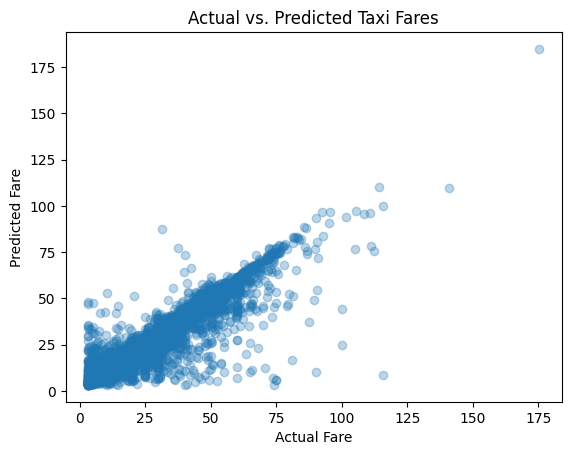

In [12]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Actual vs. Predicted Taxi Fares")
plt.show()

In [13]:
def predict_fare(trip_miles, company, payment_type,
                 pickup_area, dropoff_area,
                 trip_hour, trip_dayofweek, trip_month, trip_season):
    # Create a single-row dataframe with the same feature columns
    input_data = pd.DataFrame([{
        "trip_miles": trip_miles,
        "company": company,
        "payment_type": payment_type,
        "pickup_community_area": pickup_area,
        "dropoff_community_area": dropoff_area,
        "trip_hour": trip_hour,
        "trip_dayofweek": trip_dayofweek,
        "trip_month": trip_month,
        "trip_season": trip_season
    }])

    # Predict using trained pipeline
    return model.predict(input_data)[0]


In [14]:
predicted_fare = predict_fare(
    trip_miles=5.2,
    company="MyFleet",          # or pick an existing company seen in training
    payment_type="Cash",
    pickup_area=8,
    dropoff_area=32,
    trip_hour=18,               # 6 PM
    trip_dayofweek=5,           # Friday
    trip_month=9,               # September
    trip_season="fall"
)

print(f"Suggested fare: ${predicted_fare:.2f}")


Suggested fare: $18.63


## Train Linear Regression Model

### Subtask:
Train a Linear Regression model on the training data.

**Reasoning**:
Import and train a Linear Regression model using the preprocessed training data.

In [15]:
from sklearn.linear_model import LinearRegression

# Create a pipeline with Linear Regression
model_lr = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# Train the Linear Regression model
model_lr.fit(X_train, y_train)

# Predict using the Linear Regression model
y_pred_lr = model_lr.predict(X_test)

# Evaluate the Linear Regression model
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = mse_lr ** 0.5
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression Model Metrics:")
print(f"Mean Squared Error: {mse_lr:.2f}")
print(f"Root Mean Squared Error: {rmse_lr:.2f}")
print(f"R-squared: {r2_lr:.4f}")

Linear Regression Model Metrics:
Mean Squared Error: 33.49
Root Mean Squared Error: 5.79
R-squared: 0.8606


## Train Gradient Boosting Regression Model

### Subtask:
Train a Gradient Boosting Regression model on the training data.

**Reasoning**:
Import and train a Gradient Boosting Regression model using the preprocessed training data.

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

# Create a pipeline with Gradient Boosting Regressor
model_gb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", GradientBoostingRegressor(random_state=42))
])

# Train the Gradient Boosting model
model_gb.fit(X_train, y_train)

# Predict using the Gradient Boosting model
y_pred_gb = model_gb.predict(X_test)

# Evaluate the Gradient Boosting model
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = mse_gb ** 0.5
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting Model Metrics:")
print(f"Mean Squared Error: {mse_gb:.2f}")
print(f"Root Mean Squared Error: {rmse_gb:.2f}")
print(f"R-squared: {r2_gb:.4f}")

Gradient Boosting Model Metrics:
Mean Squared Error: 20.60
Root Mean Squared Error: 4.54
R-squared: 0.9143


## Compare Model Results

### Subtask:
Compare the performance metrics of the trained models.

**Reasoning**:
Create a DataFrame to compare the evaluation metrics (MSE, RMSE, and R-squared) for the Random Forest, Linear Regression, and Gradient Boosting models and display the results.

In [17]:
# Create a dictionary to store the metrics
model_comparison = {
    'Model': ['Random Forest', 'Linear Regression', 'Gradient Boosting'],
    'MSE': [mse, mse_lr, mse_gb],
    'RMSE': [rmse, rmse_lr, rmse_gb],
    'R-squared': [r2, r2_lr, r2_gb]
}

# Create a DataFrame from the dictionary
comparison_df = pd.DataFrame(model_comparison)

# Display the comparison table
display(comparison_df)

,Model,MSE,RMSE,R-squared
0,Random Forest,15.805261,3.975583,0.934209
1,Linear Regression,33.490644,5.787110,0.860592
2,Gradient Boosting,20.595556,4.538233,0.914269
